### Import packages to be used

In [12]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import re
import matplotlib.gridspec as gridspec
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib notebook

### Get Annual Population Data for New Haven from Census Data

In [2]:
# Compile Census Population Data into Data Frame
years = np.arange(2010,2019)
year_ind = -1
# For each year available to us, read in file and 
for year in years:
    year_ind+=1
    df_j = pd.read_csv('productDownload_2020-09-21T100438\ACSDP1Y'+str(year)+
                       '.DP05_data_with_overlays_2020-09-21T100421.csv',skiprows = 0)
    df_j = df_j.iloc[1:]
    df_j.rename(columns={'DP05_0001E':'Total Population'}, inplace=True)
    df_j['Year'] = year
    if year_ind==0:
        df_pop = df_j.copy()
    else:
        df_pop=df_pop.append(df_j.copy())
df_pop = df_pop[['Total Population','Year']].astype(int)
df_pop

C:\Users\peter\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,Total Population,Year
1,129849,2010
1,129591,2011
1,130749,2012
1,130654,2013
1,130285,2014
1,130310,2015
1,129939,2016
1,131005,2017
1,130407,2018


### Create Dataframe of Reported Crimes in New Haven

In [3]:
of = 'NewHavenCrimeData/' # directory for crime data
# Files containing crime data from ucr
crimefiles = ['new-haven-police-department-aggravated-assault.csv','new-haven-police-department-arson.csv',
              'new-haven-police-department-burglary.csv', 'new-haven-police-department-homicide.csv',
              'new-haven-police-department-larceny.csv','new-haven-police-department-motor-vehicle-theft.csv',
              'new-haven-police-department-rape.csv','new-haven-police-department-robbery.csv']
i = -1
Crimes = []
for file in crimefiles:
    i+=1
    # Make descriptive Column title from file name string
    CrimeName = ''
    CrimeNames = re.split('-',file[:-4])[4:]
    for name in CrimeNames:
        CrimeName += name.capitalize()
        CrimeName += ' '
    CrimeName = CrimeName.strip()
    Crimes.append(CrimeName)
    # Read in file, and extract reported crime information
    df_crime_i = pd.read_csv(of+file)
    if CrimeName=='Rape':
        df_crime_i = df_crime_i.iloc[np.where((df_crime_i['Label']=='Revised Rape Reported').astype(int)+
                                              (df_crime_i['Label']=='Legacy Rape Reported').astype(int))]
    else:
        df_crime_i = df_crime_i.iloc[np.where(df_crime_i['Label']=='Reported')]
    
    # Rename value column with descriptive title
    df_crime_i.rename(columns={'Value':CrimeName}, inplace=True)
    df_crime_i.drop(columns='Label',inplace=True)
    
    # Append to dataframe
    if i==0:
        df_crimes = df_crime_i.copy()
    else:
        df_crimes=df_crimes.merge(df_crime_i,how= 'outer',on='Year')
df_crimes.drop_duplicates(inplace=True)
df_crimes = (df_crimes.merge(df_pop,how='inner', on='Year')).astype(float)
df_crimes['Year'] = df_crimes['Year'].astype(int)
df_crimes.set_index('Year', inplace=True)
# Convert to rate per 100k
df_crimes.iloc[:,:-1] = df_crimes.iloc[:,:-1]/np.tile(df_crimes['Total Population'],(np.shape(df_crimes)[1]-1,1)).T*100000
df_crimes.reset_index(inplace=True)
df_crimes

,Year,Aggravated Assault,Arson,Burglary,Homicide,Larceny,Motor Vehicle Theft,Rape,Robbery,Total Population
0,2010,857.919584,13.092130,1078.175419,17.712882,3724.325948,780.907054,53.908771,606.088611,129849.0
1,2011,691.406039,13.889853,1091.896814,26.236390,3200.067906,728.445648,44.756194,591.862089,129591.0
2,2012,733.466413,11.472363,1121.997109,13.002011,3375.169217,556.027197,45.889452,646.276453,130749.0
3,2013,619.958057,11.480705,842.683730,15.307606,3290.369985,588.577464,61.230425,602.354310,130654.0
4,2014,564.915378,11.513221,771.385808,9.978125,2780.059101,461.296389,62.938942,455.923552,130285.0
5,2015,527.204359,23.022024,665.336505,11.511012,2828.639398,540.250173,49.881053,353.004374,130310.0
6,2016,569.497995,16.161430,640.300449,10.004695,3022.187334,565.650036,53.871432,307.836754,129939.0
7,2017,506.087554,24.426549,641.196901,5.343308,2851.799550,491.584291,40.456471,288.538605,131005.0
8,2018,550.583941,13.802940,577.422991,7.668300,2850.307115,519.910741,49.077120,246.919260,130407.0


### Create Dataframe of Income Distribution by Census Tract from Annual Census Data

In [4]:
# Compile Census Data of Income Related Information into Data Frame
years = np.arange(2010,2019)
year_ind = -1
# For each year available to us, read in file and 
for year in years:
    year_ind+=1
    df_i = pd.read_csv('productDownload_2020-09-14T154628\ACSST5Y'+str(year)+
                       '.S1901_data_with_overlays_2020-09-14T154416.csv',skiprows = 0)
    df_i = df_i.iloc[1:]
    Tracts = df_i['NAME']
    # Extract census tract and 
    CensusTracts = []
    Counties=[]
    for tract in Tracts:
        ind = tract.index('Tract')
        ind_comma = tract.index(',')
        CensusTracts.append(tract[ind+6:ind_comma])
        Counties.append(tract[ind_comma+1:ind_comma+1+tract[ind_comma+1:].index(',')].strip())
    df_i['County'] = Counties
    df_i['Census Tract'] = CensusTracts
    df_i['Census Tract'].astype(float)
    df_i = df_i.iloc[np.where(df_i['County']=='New Haven County')]
    df_i.set_index(['Census Tract'], inplace=True)
    df_i['Year'] = year
    if year_ind==0:
        df = df_i.copy()
    else:
        df=df.append(df_i.copy())
df.reset_index(inplace=True)

# Clean up all missing values with NaN
df.iloc[np.where(df=='(X)')]= np.nan
df.iloc[np.where(df=='-')]= np.nan
df.iloc[np.where(df=='**')]= np.nan
df.iloc[np.where(df=='***')]= np.nan
df.iloc[np.where(df=='N')]= np.nan

df.iloc[:,4:] = df.iloc[:,4:].astype(float)
df['Census Tract'] = df['Census Tract'].astype(float)*100
df

C:\Users\peter\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,Census Tract,County,GEO_ID,NAME,S1901_C01_001E,S1901_C01_001M,S1901_C01_002E,S1901_C01_002M,S1901_C01_003E,S1901_C01_003M,...,S1901_C04_012M,S1901_C04_013E,S1901_C04_013M,S1901_C04_014E,S1901_C04_014M,S1901_C04_015E,S1901_C04_015M,S1901_C04_016E,S1901_C04_016M,Year
0,125400.0,New Haven County,1400000US09009125400,"Census Tract 1254, New Haven County, Connecticut",1300.0,115.0,8.4,4.1,6.2,3.7,...,NaN,35829.0,8027.0,NaN,NaN,NaN,NaN,17.7,NaN,2010.0
1,130101.0,New Haven County,1400000US09009130101,"Census Tract 1301.01, New Haven County, Connec...",2017.0,93.0,2.4,1.9,2.6,2.0,...,NaN,42226.0,7501.0,NaN,NaN,NaN,NaN,26.1,NaN,2010.0
2,130102.0,New Haven County,1400000US09009130102,"Census Tract 1301.02, New Haven County, Connec...",1173.0,91.0,11.0,7.8,5.5,5.7,...,NaN,33658.0,12536.0,NaN,NaN,NaN,NaN,0.0,NaN,2010.0
3,130200.0,New Haven County,1400000US09009130200,"Census Tract 1302, New Haven County, Connecticut",3254.0,117.0,4.5,3.1,4.1,2.7,...,NaN,52954.0,10075.0,NaN,NaN,NaN,NaN,37.2,NaN,2010.0
4,140100.0,New Haven County,1400000US09009140100,"Census Tract 1401, New Haven County, Connecticut",1403.0,143.0,25.4,8.5,5.1,5.8,...,NaN,45113.0,9402.0,NaN,NaN,NaN,NaN,12.4,NaN,2010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1705,361300.0,New Haven County,1400000US09009361300,"Census Tract 3613, New Haven County, Connecticut",1487.0,94.0,0.7,1.1,1.3,1.8,...,NaN,67565.0,13479.0,NaN,NaN,NaN,NaN,37.6,NaN,2018.0
1706,361401.0,New Haven County,1400000US09009361401,"Census Tract 3614.01, New Haven County, Connec...",1398.0,109.0,25.3,6.2,8.0,3.2,...,NaN,41321.0,8023.0,NaN,NaN,NaN,NaN,17.4,NaN,2018.0
1707,361402.0,New Haven County,1400000US09009361402,"Census Tract 3614.02, New Haven County, Connec...",152.0,42.0,12.5,12.0,0.0,20.4,...,NaN,56642.0,14093.0,NaN,NaN,NaN,NaN,13.1,NaN,2018.0
1708,361500.0,New Haven County,1400000US09009361500,"Census Tract 3615, New Haven County, Connecticut",1869.0,134.0,8.0,4.2,6.4,4.4,...,NaN,43520.0,6850.0,NaN,NaN,NaN,NaN,28.3,NaN,2018.0


### Create Dictionary and String Arrays for Income Brackets

In [5]:
# Income Category for % within each bracket
IncomeCat = ['S1901_C01_002E','S1901_C01_003E','S1901_C01_004E',
             'S1901_C01_005E','S1901_C01_006E','S1901_C01_007E',
             'S1901_C01_008E','S1901_C01_009E','S1901_C01_010E',
             'S1901_C01_011E']
IncomeErr = ['S1901_C01_002M','S1901_C01_003M','S1901_C01_004M',
             'S1901_C01_005M','S1901_C01_006M','S1901_C01_007M',
             'S1901_C01_008M','S1901_C01_009M','S1901_C01_010M',
             'S1901_C01_011M']

IncomeEdges = np.array([0,10000,14999,24999,34999,49999,74999,99999,149999,199999,249999])

# Make dictionary to translate column titles to income brackets
IncomeDict = {}
IncomeErrDict = {}
IncomeDivStrs = []
IncomeErrStrs = []
for i in np.arange(0,len(IncomeCat)):
    if i == len(IncomeCat)-1:
         IncomeDivStrs.append('$' + str(IncomeEdges[i]) + '+')
    else:
         IncomeDivStrs.append('$' + str(IncomeEdges[i]) + '-$' + str(IncomeEdges[i+1]))
    IncomeDict[IncomeCat[i]] = IncomeDivStrs[i]
    IncomeErrStrs.append(IncomeDivStrs[i]+ ' Err')
    IncomeErrDict[IncomeErr[i]] = IncomeErrStrs[i]

## Merge Crime Data with Income Bracket Data

In [6]:
# Find subset of census tracts for the city of new haven and convert to format to match map
NewHavenTracts = np.unique(df['Census Tract'])
NewHavenTracts = NewHavenTracts[(NewHavenTracts>140000) *( NewHavenTracts<150000)]
NewHavenTracts = np.append(NewHavenTracts,np.array([361401,361402]))
NewHavenTracts = NewHavenTracts.astype(int).astype(str)
#NewHavenTracts
df2 = df.copy()
df2['Census Tract'] = df2['Census Tract'].astype(int).astype(str)
df2.set_index('Census Tract', inplace=True)
df2 = df2.T[NewHavenTracts]
df2 = df2.T.reset_index()
df2 = df2.rename(columns=IncomeDict)
df2 = df2.rename(columns=IncomeErrDict)
# Merge Income dataframe with Crime Dataframe
df_tot = df2.merge(df_crimes,on='Year',how='inner')
df_tot

,Census Tract,County,GEO_ID,NAME,S1901_C01_001E,S1901_C01_001M,$0-$10000,$0-$10000 Err,$10000-$14999,$10000-$14999 Err,...,Year,Aggravated Assault,Arson,Burglary,Homicide,Larceny,Motor Vehicle Theft,Rape,Robbery,Total Population
0,140100,New Haven County,1400000US09009140100,"Census Tract 1401, New Haven County, Connecticut",1403,143,25.4,8.5,5.1,5.8,...,2010,857.919584,13.09213,1078.175419,17.712882,3724.325948,780.907054,53.908771,606.088611,129849.0
1,140200,New Haven County,1400000US09009140200,"Census Tract 1402, New Haven County, Connecticut",719,60,41.3,15.5,22.4,9.1,...,2010,857.919584,13.09213,1078.175419,17.712882,3724.325948,780.907054,53.908771,606.088611,129849.0
2,140300,New Haven County,1400000US09009140300,"Census Tract 1403, New Haven County, Connecticut",713,118,11.4,9,10.2,7.2,...,2010,857.919584,13.09213,1078.175419,17.712882,3724.325948,780.907054,53.908771,606.088611,129849.0
3,140400,New Haven County,1400000US09009140400,"Census Tract 1404, New Haven County, Connecticut",1214,102,24.1,8,7.8,5.6,...,2010,857.919584,13.09213,1078.175419,17.712882,3724.325948,780.907054,53.908771,606.088611,129849.0
4,140500,New Haven County,1400000US09009140500,"Census Tract 1405, New Haven County, Connecticut",1111,111,12.2,5.7,7.4,5.4,...,2010,857.919584,13.09213,1078.175419,17.712882,3724.325948,780.907054,53.908771,606.088611,129849.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,142604,New Haven County,1400000US09009142604,"Census Tract 1426.04, New Haven County, Connec...",1000,85,13.5,6.9,4.8,4.6,...,2018,550.583941,13.80294,577.422991,7.668300,2850.307115,519.910741,49.077120,246.919260,130407.0
275,142700,New Haven County,1400000US09009142700,"Census Tract 1427, New Haven County, Connecticut",2387,177,7.1,5,8,6.1,...,2018,550.583941,13.80294,577.422991,7.668300,2850.307115,519.910741,49.077120,246.919260,130407.0
276,142800,New Haven County,1400000US09009142800,"Census Tract 1428, New Haven County, Connecticut",1940,127,3.8,2.6,0,1.8,...,2018,550.583941,13.80294,577.422991,7.668300,2850.307115,519.910741,49.077120,246.919260,130407.0
277,361401,New Haven County,1400000US09009361401,"Census Tract 3614.01, New Haven County, Connec...",1398,109,25.3,6.2,8,3.2,...,2018,550.583941,13.80294,577.422991,7.668300,2850.307115,519.910741,49.077120,246.919260,130407.0


### Make Interactive Graphic for distribution of income for a chosen census tract and see how that compares to a trend in a crime rate

<IPython.core.display.Javascript object>


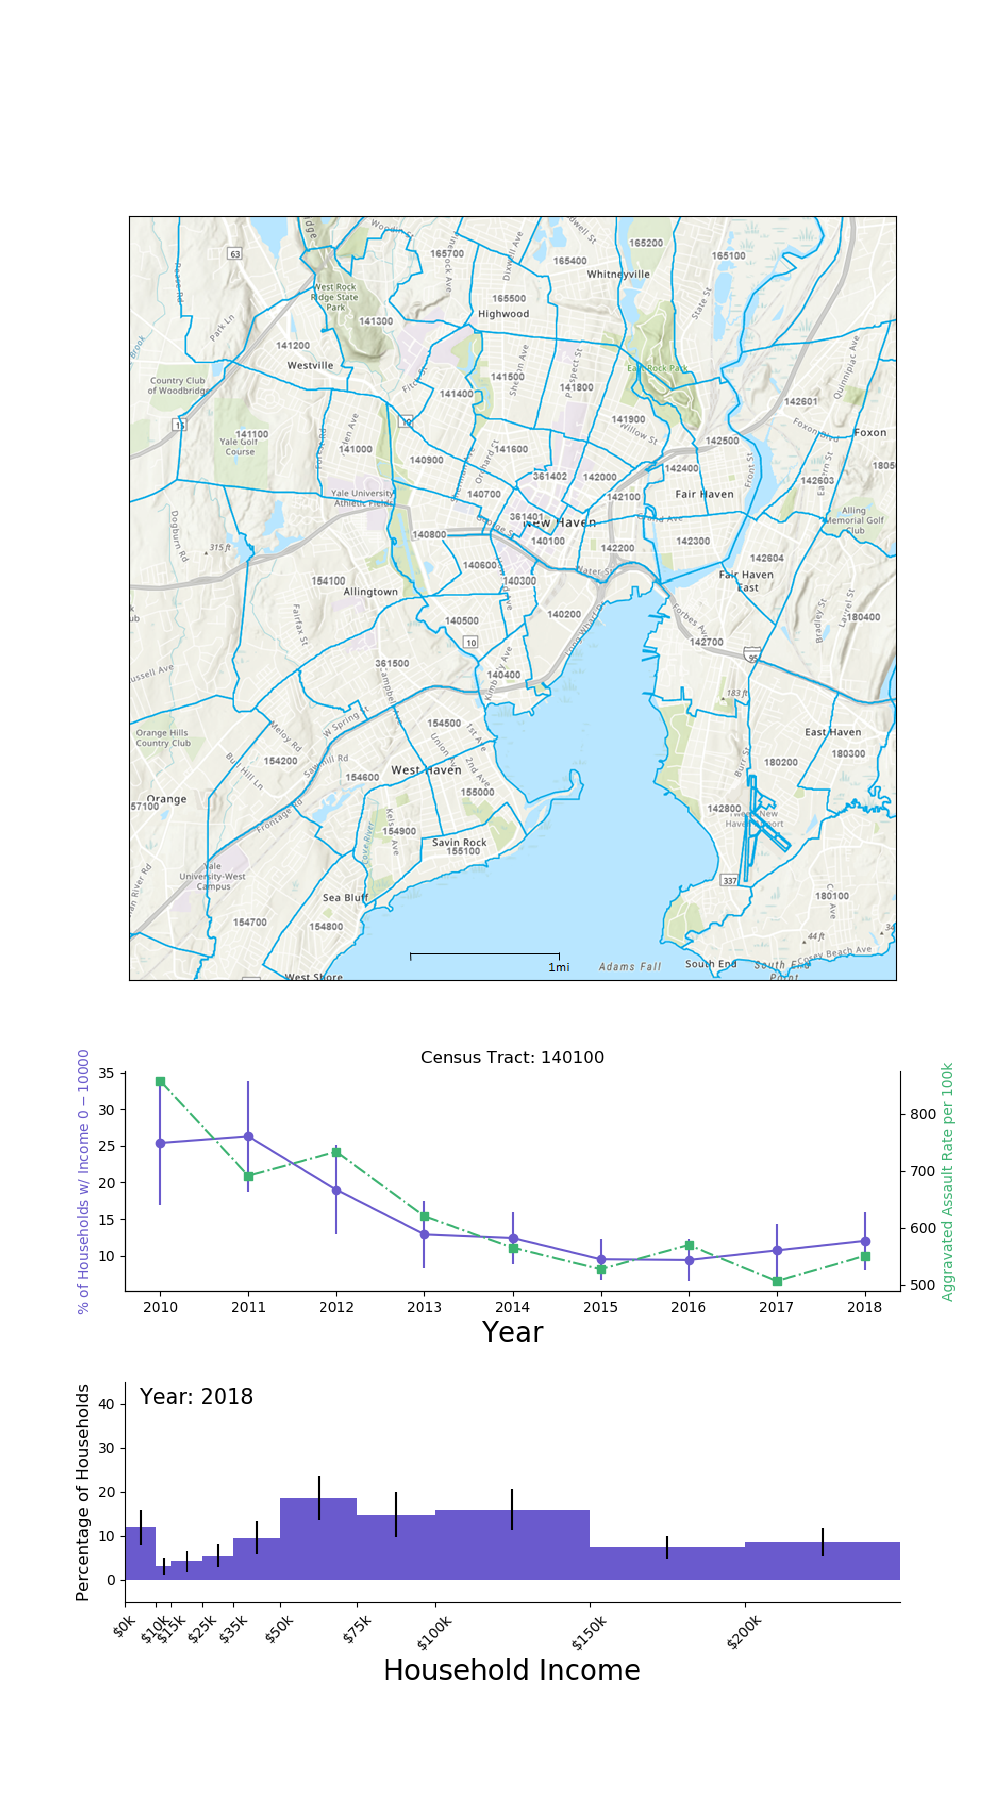

interactive(children=(Dropdown(description='CensusTract', options=('140100', '140200', '140300', '140400', '14…

<function __main__.f(CensusTract, Crime, IncomeBracket)>

In [114]:
# Load in map of census tracts for new haven
img = mpimg.imread('NewHavenCensus.png')

# Set up boxes for figure
top_sz = 10
fig = plt.figure(figsize=(top_sz,top_sz+8))
gspec = gridspec.GridSpec(top_sz+8,top_sz)
ax_top = plt.subplot(gspec[:top_sz, :])
ax_top.set_xticks([])
ax_top.set_yticks([])
ax_top.imshow(img)
ax_mid = plt.subplot(gspec[top_sz+1:top_sz+4, :])
ax2 = ax_mid.twinx()
ax_bot = plt.subplot(gspec[top_sz+5:, :])

# Define Variables for bar plot
IncomeEdges = np.array([0,10000,14999,24999,34999,49999,74999,99999,149999,199999,250001])
IncomeEdges = np.array([0,10,15,25,35,50,75,100,150,200,250.001])
IncWidths = IncomeEdges[1:] - IncomeEdges[:-1]
IncomeBins = 0.5*(IncomeEdges[1:]+IncomeEdges[:-1])
IncomeEdgesLabels = ['$'+ substr+'k' for substr in IncomeEdges.astype(int).astype(str)]
color0 = 'slateblue'
color1 = 'mediumseagreen'

def make_slc_plot(df_slc, Crime, IncomeBracket):
    ax_mid.cla()
    ax2.cla()
    Years = df_slc['Year']
    y1 = df_slc[IncomeBracket]
    y1err = df_slc[IncomeBracket+' Err']
    y2 = df_slc[Crime]
    ax_mid.errorbar(Years,y1,yerr=y1err,linestyle='-',marker='o',color=color0)
    ax_mid.set_ylabel(r'% of Households w/ Income '+IncomeBracket, color=color0)
    ax2.plot(Years,y2,'-.s', color=color1)
    ax2.set_ylabel(Crime+' Rate per 100k', color=color1)
    ax_mid.set_xlabel('Year', fontsize=20)
    i=0
    for spine in ax2.spines.values():
        i+=1
        if i==4:
            spine.set_visible(False)
    i=0
    for spine in ax_mid.spines.values():
        i+=1
        if i==2 or i==4:
            spine.set_visible(False)
    
def make_income_plot(df_slc, Year):
    # Income Distribution Plot
    year_ind = np.where(years==Year)[0][0]
    ax_bot.cla()
    
    IncomeDivStrs2 = IncomeDivStrs.copy()
    IncomeDivStrs2.append('Year')
    IncomeErrStrs2 = IncomeErrStrs.copy()
    IncomeErrStrs2.append('Year')
    ys = df_slc[IncomeDivStrs2]
    ys.set_index('Year',inplace=True)
    y_errs = df_slc[IncomeErrStrs2]
    y_errs.set_index('Year',inplace=True)
    ax_bot.bar(IncomeBins,ys.iloc[year_ind], width = IncWidths,yerr=y_errs.iloc[year_ind], color='slateblue')
    ax_bot.set_xticks(IncomeEdges)
    ax_bot.set_xticklabels(IncomeEdgesLabels,rotation=45, ha='center')
    ax_bot.set_xlabel('Household Income', fontsize=20)
    ax_bot.set_ylabel('Percentage of Households', fontsize=12)
    ax_bot.set_ylim([-5,45])
    ax_bot.set_xlim([0,250])
    ax_bot.annotate('Year: %d' %Year, [5,40],fontsize=15)
    i=0
    for spine in ax_bot.spines.values():
        i+=1
        if i==2 or i==4:
            spine.set_visible(False)
            
    fig.savefig('Test.png')
    
def f(CensusTract, Crime, IncomeBracket):
    df_slc = df_tot.iloc[np.where(df_tot['Census Tract']==CensusTract)]
    make_slc_plot(df_slc, Crime, IncomeBracket)
    
    ax_mid.set_title('Census Tract: '+str(CensusTract))
    interact(make_income_plot, Year=(2010,2018,1),df_slc = fixed(df_slc))
    return 
    
interact(f, CensusTract=NewHavenTracts, Crime=Crimes, IncomeBracket=IncomeDivStrs)

<IPython.core.display.Javascript object>


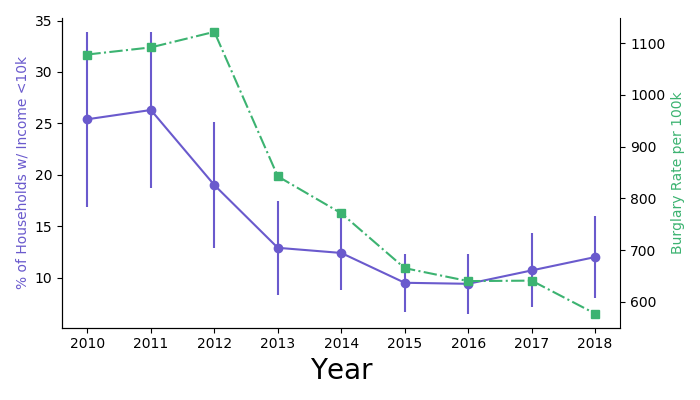

In [113]:
def make_slc_plot(df_slc, Crime, IncomeBracket1):
    ax_mid.cla()
    ax2.cla()
    Years = df_slc['Year']
    y1 = df_slc[IncomeBracket1]
    #y3 = df_slc[IncomeBracket2]
    y1err = df_slc[IncomeBracket1+' Err']
    #y3err = df_slc[IncomeBracket2+' Err']
    y2 = df_slc[Crime]
    ax_mid.errorbar(Years,y1,yerr=y1err,linestyle='-',marker='o',color=color0)
    #ax_mid.errorbar(Years,y3,yerr=y3err,linestyle='--',marker='<',color=color0)
    #ax_mid.legend([IncomeBracket1, IncomeBracket2])
    ax_mid.set_ylabel(r'% of Households w/ Income <10k', color=color0)
    ax2.plot(Years,y2,'-.s', color=color1)
    ax2.set_ylabel(Crime+' Rate per 100k', color=color1)
    ax_mid.set_xlabel('Year', fontsize=20)
    i=0
    for spine in ax2.spines.values():
        i+=1
        if i==4:
            spine.set_visible(False)
    i=0
    for spine in ax_mid.spines.values():
        i+=1
        if i==2 or i==4:
            spine.set_visible(False)
    return y1,y2
    
f, ax_mid = plt.subplots(figsize=(7,4))
ax2 = ax_mid.twinx()

CensusTract = '140100'
df_slc = df_tot.iloc[np.where(df_tot['Census Tract']==CensusTract)]
Crime = 'Burglary'

y1,y2 = make_slc_plot(df_slc, Crime, IncomeDivStrs[0])
f.tight_layout()
f.savefig('LowIncomeBurglary.png')